# Twitter User Embedding and Clustering

This notebook extends techniques introduced in the paper "user2Vec: Social Media User Representation Based on Distributed Document Embeddings" (Hallac, et al. 2019). The paper proposes calculating meaningful vector embeddings of twitter accounts by averaging the embeddings of individual tweets generated by doc2vec. The authors demonstrate some sucess with this method. However, we think that a better representation could be found by first clustering individual tweet embeddings per account. Then representing each account using it's the centroids of it's largest clusters.

# Download the Data

In [ ]:
!wget http://buyukveri.firat.edu.tr/wp-content/uploads/2020/09/test_users.zip
!unzip ./test_users.zip
!pip install sentence-transformers
!pip install sklearn --upgrade

--2022-04-29 18:33:10--  http://buyukveri.firat.edu.tr/wp-content/uploads/2020/09/test_users.zip
Resolving buyukveri.firat.edu.tr (buyukveri.firat.edu.tr)... 193.255.124.244
Connecting to buyukveri.firat.edu.tr (buyukveri.firat.edu.tr)|193.255.124.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15094515 (14M) [application/zip]
Saving to: ‘test_users.zip’

test_users.zip      100%[===================>]  14.39M  7.15MB/s    in 2.0s    

2022-04-29 18:33:14 (7.15 MB/s) - ‘test_users.zip’ saved [15094515/15094515]

Archive:  ./test_users.zip
   creating: test_users/
  inflating: test_users/twcollector2_bennydoda01.csv  
   creating: __MACOSX/
   creating: __MACOSX/test_users/
  inflating: __MACOSX/test_users/._twcollector2_bennydoda01.csv  
  inflating: test_users/twcollector2_cryptonator1337.csv  
  inflating: __MACOSX/test_users/._twcollector2_cryptonator1337.csv  
  inflating: test_users/twcollector2_CryptoCobain.csv  
  inflating: __MACOSX/test_users/._twco

# Download the Embedding Model

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
# sbert_model = SentenceTransformer('average_word_embeddings_glove.6B.300d')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/383 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

# Read all the tweet csv files, store them in a dictionary

In [ ]:
import os
import re
import csv
import numpy as np

# Store all the tweets by category and account
tweets = {}

# Read everything into memory
directory = "test_users"
total_tweets = 0
for filename in os.listdir(directory):
  f = os.path.join(directory, filename)
  if os.path.isfile(f):
    category_key = re.findall(r'twcollector\d_', f)[0].replace('twcollector', '').replace('_', '')
    account_name = re.sub(r'.+\/twcollector\d_', '', f).replace('.csv', '')
    account_tweets = []
    if category_key not in tweets:
      tweets[category_key] = {}
    with open(f, 'r') as csvfile:
      csvreader = csv.reader(csvfile)
      for row in csvreader:
        account_tweets.append(row[3])
        total_tweets += 1
    tweets[category_key][account_name] = account_tweets


# Calculate the account embeddings, store the correct labels

In [ ]:
# Calculate the average embedding for each account
targets = []
embeddings = []
tweet_targets = []
tweet_embeddings = {}
account_targets = {}

count = 0
for category_key in tweets:
  for account in tweets[category_key]:
    tweet_embs = sbert_model.encode(tweets[category_key][account]) # Embed all the tweets for the current account
    tweet_embeddings[account] = tweet_embs # Keep the individual embeddings for later use
    tweet_targets += [int(category_key)]*tweet_embs.shape[0]
    tweet_embs = np.sum(tweet_embs, axis=0) / tweet_embs.shape[1] # Average the tweets embeddings
    tweet_embs = np.expand_dims(tweet_embs, axis=0)
    embeddings.append(np.sum(tweet_embs, axis=0))
    targets.append(int(category_key)-1)
    count += tweet_embs.shape[0]

    #Create a dictionary of account names linked to their target categories
    account_targets[account] = category_key
    print('\r' + str(round((count/(tweet_embs.shape[0]*len(tweets[category_key])*len(tweets)))*100, 2)) + '% Complete', end='')
targets = np.array(targets)
embeddings = np.stack(embeddings)
tweet_targets = np.array(tweet_targets)
print("")
print('Targets: ' + str(targets.shape))
print('Embeddings: ' + str(embeddings.shape))
print('Tweet Targets: ' + str(tweet_targets.shape))
print('Tweet Embeddings: ' + str(len(tweet_embeddings)))

100.0% Complete
Targets: (200,)
Embeddings: (200, 384)
Tweet Targets: (200000,)
Tweet Embeddings: 200


# Visualize the data

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0.5, 1.0, 't-SNE Projection')]

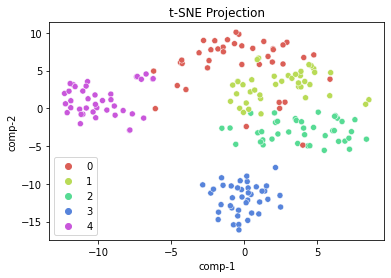

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from numpy import reshape
import seaborn as sns
import pandas as pd

# sc = StandardScaler()
# embeddings_scaled = sc.fit_transform(embeddings)
# pca = PCA(n_components=30)
# embeddings_pca = pca.fit_transform(embeddings_scaled)

tsne = TSNE(n_components=2, verbose=0)
z = tsne.fit_transform(embeddings)

# lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
# z = lda.fit_transform(embeddings, targets)

df = pd.DataFrame()
df["y"] = targets
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="t-SNE Projection") 

# Get the centroids for each category (average the category embeddings)

In [ ]:
def get_centroids(embeddings, targets):
  sums = {}
  counts = {}
  for i in range(targets.shape[0]):
    if targets[i] in sums:
      sums[targets[i]] += embeddings[i]
      counts[targets[i]] += 1
    else:
      sums[targets[i]] = embeddings[i]
      counts[targets[i]] = 1
  centers = np.zeros((np.unique(targets).shape[0], sums[0].shape[0]), dtype=np.float64)
  for yi in sums:
    centers[yi] = sums[yi] / counts[yi]
  return centers

In [ ]:
def get_closest_center(embedding, centroids):
  max_sim = 0
  closest = False
  for c in centroids:
    cos_sim = np.dot(c, embedding)/(np.linalg.norm(c)*np.linalg.norm(embedding))
    if cos_sim > max_sim:
      max_sim = cos_sim
      closest = c
  return closest

# Accuracy by groups

Percentage of datapoints in each category that are closest to the centroid of the category they belong to.

In [ ]:
def accuracy_by_groups(embeddings, targets):
  centroids = get_centroids(embeddings, targets)
  accuracies = {}
  counts = {}
  for i in range(targets.shape[0]):
    correct = False
    if (get_closest_center(embeddings[i], centroids) == centroids[targets[i]]).all():
      correct = True
    if targets[i] in counts:
      counts[targets[i]] += 1
    else:
      counts[targets[i]] = 1
    if targets[i] in accuracies and correct:
      accuracies[targets[i]] += 1
    elif targets[i] not in accuracies and correct:
      accuracies[targets[i]] = 1
    elif targets[i] not in accuracies and not correct:
      accuracies[targets[i]] = 0
  avg_acc = 0
  for y in accuracies:
    accuracies[y] /= counts[y]
    avg_acc += accuracies[y]
  avg_acc /= len(accuracies)
  return accuracies, avg_acc

def print_accuracy(accuracies, avg_acc):
  print('  Accuracy')
  for y in sorted(accuracies):
    print(str(y) + ' ' + str(accuracies[y]))
  print('\nAverage: ' + str(round(avg_acc, 4)))

In [ ]:
accs, avg_acc = accuracy_by_groups(embeddings, targets)
print_accuracy(accs, avg_acc) # Print accuracy by groups for unreduced data

  Accuracy
0 0.825
1 0.9
2 0.95
3 1.0
4 1.0

Average: 0.935


# Similarity Across Groups

Cosine similarity between category centroids.

In [ ]:
def similarity_accross_groups(embeddings, targets):
  centroids = get_centroids(embeddings, targets)
  sims = np.zeros((len(centroids), len(centroids)))
  avg = 0
  count = 0
  for c in range(len(centroids)):
    for cj in range(len(centroids)):
      cos_sim = np.dot(centroids[c], centroids[cj])/(np.linalg.norm(centroids[c])*np.linalg.norm(centroids[cj]))
      sims[c][cj] = cos_sim
      if c != cj:
        avg += cos_sim
        count += 1
  avg /= count
  return sims, avg

def print_similarity_accross_groups(sims, avg):
  line = '  '
  for i in range(sims.shape[0]):
    line += str(i+1) + '     '
  print(line)

  for i in range(sims.shape[0]):
    line = str(i+1) + ' '
    for j in range(sims.shape[1]):
      line += '{:.3f} '.format(round(sims[i][j], 3))
    print(line)
  print('\nAverage: ' + str(round(avg, 3)))

In [ ]:
sims, avg = similarity_accross_groups(embeddings, targets)
print_similarity_accross_groups(sims, avg) # Print similarity groups for unreduced data

  1     2     3     4     5     
1 1.000 0.872 0.784 0.572 0.688 
2 0.872 1.000 0.837 0.620 0.581 
3 0.784 0.837 1.000 0.625 0.645 
4 0.572 0.620 0.625 1.000 0.475 
5 0.688 0.581 0.645 0.475 1.000 

Average: 0.67


# Test different dimensionality reduction methods
Compare results between them using accuracy by groups and similarity across groups. Ideally, accuracy will be high, and similarity will be low (centroids are far away).

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

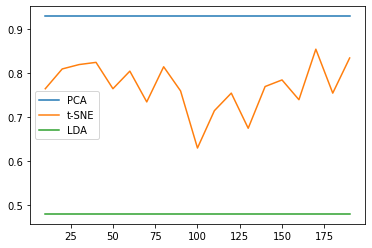

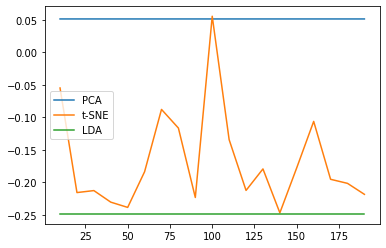

In [ ]:
import matplotlib.pyplot as plt

min_dim = min(embeddings.shape[0], embeddings.shape[1])
dim_range = [10, min_dim] # lower and upper bound for testing dim reduction
dim_resolution = 10 # number of dims to add every step

x_axis = []

# PCA
count = 0
pca_acc_axis = []
pca_sim_axis = []
sc = StandardScaler()
embeddings_scaled = sc.fit_transform(embeddings)
current_dim = dim_range[0]
while current_dim < dim_range[1]:
  x_axis.append(current_dim)
  pca = PCA(n_components=current_dim)
  embeddings_pca = pca.fit_transform(embeddings_scaled)
  _, acc_avg = accuracy_by_groups(embeddings_pca, targets)
  pca_acc_axis.append(acc_avg)
  _, sim_avg = similarity_accross_groups(embeddings_pca, targets)
  pca_sim_axis.append(sim_avg)
  current_dim += dim_resolution
  count += 1


# t-SNE
tsne_acc_axis = []
tsne_sim_axis = []
current_dim = dim_range[0]
while current_dim < dim_range[1]:
  tsne = TSNE(n_components=2, verbose=0)
  embeddings_tsne = tsne.fit_transform(embeddings)
  _, acc_avg = accuracy_by_groups(embeddings_tsne, targets)
  tsne_acc_axis.append(acc_avg)
  _, sim_avg = similarity_accross_groups(embeddings_tsne, targets)
  tsne_sim_axis.append(sim_avg)
  current_dim += dim_resolution

# LDA - kind of cheating, only doing this in 4d and extending it to display on the chart
lda = LinearDiscriminantAnalysis(n_components=4, solver='svd')
embeddings_lda = lda.fit_transform(embeddings, targets)
_, acc_avg = accuracy_by_groups(embeddings_lda, targets)
lda_acc_axis = [acc_avg]*count
_, sim_avg = similarity_accross_groups(embeddings_lda, targets)
lda_sim_axis = [sim_avg]*count

plt.plot(x_axis, pca_acc_axis, label="PCA")
plt.plot(x_axis, tsne_acc_axis, label="t-SNE")
plt.plot(x_axis, lda_acc_axis, label="LDA")
plt.legend()
plt.show()

plt.plot(x_axis, pca_sim_axis, label="PCA")
plt.plot(x_axis, tsne_sim_axis, label="t-SNE")
plt.plot(x_axis, lda_sim_axis, label="LDA")
plt.legend()
plt.show()

# Calculate Individual Acount Representations by Clustering the Embeddings
For each individual twitter account, cluster the embedding for each tweet using the number of clusters that maximizes the silhouette score.

Why does this break when put inside a function?!?!?!
I'm sorry that we have to copy/paste the Agglomerative Clustering code with the loop everywhere but as you can see I attempted to put it in a function which caused AgglomerativeClustering to label incorrectly, and you have to restart the runtime to fix it.

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics import silhouette_score

# # Helper function that takes embedding, finds optimal number of clusters with
# # the silhouette method, and returns the centroids (highest frequency first),
# # the labels, and the most populated cluster.
# def cluster_tweets(tweet_embs, min_n=3, max_n=10):
#   # Try 3-10 clusters, calculate silhouette score of each
#   max_sil = -1
#   best_n = 0
#   best_labels = []
#   best_centers = []
#   for n_clusters in range(min_n, max_n+1):
#     cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
#     cluster.fit_predict(tweet_embs)
#     sil_score = silhouette_score(tweet_embs, cluster.labels_)
#     if sil_score > max_sil:
#       max_sil = sil_score
#       best_n = n_clusters
#       best_labels = cluster.labels_
#       best_centers = get_centroids(tweet_embs, cluster.labels_)

#   counts = [0]*best_n
#   biggest_cluster = 0
#   biggest_cluster_count = 0
#   for i in range(len(best_labels)):
#     counts[best_labels[i]] += 1
#   for i in range(len(counts)):
#     if counts[i] > biggest_cluster_count:
#       biggest_cluster_count = counts[i]
#       biggest_cluster = i
  
#   return best_centers, best_labels, biggest_cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

Visualize the first few accounts with t-SNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


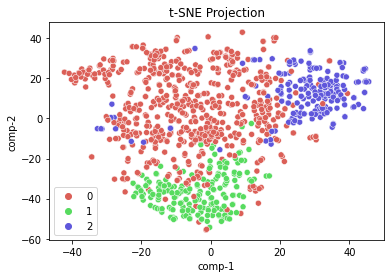

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


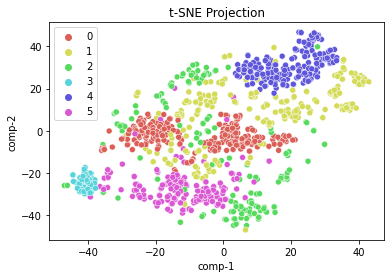

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


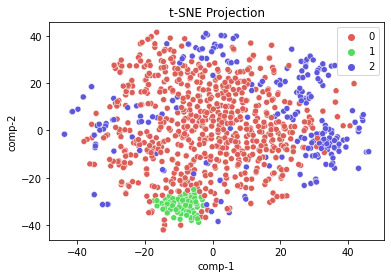

In [ ]:
# Visualize the first few account
count = 0
for account in tweet_embeddings:
  count += 1
  if count >= 4:
    break

  # Try 2-10 clusters, calculate silhouette score of each
  max_sil = -1
  best_n = 0
  best_labels = []
  for n_clusters in range(3, 11):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster.fit_predict(tweet_embeddings[account])
    sil_score = silhouette_score(tweet_embeddings[account], cluster.labels_)
    if sil_score > max_sil:
      max_sil = sil_score
      best_n = n_clusters
      best_labels = cluster.labels_
  # # Try 3-10 clusters, calculate silhouette score of each
  # scores = []
  # score_ns = []
  # max_sil = -1
  # best_n = 0
  # best_labels = []
  # for n_clusters in range(3,10):
  #   cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
  #   cluster.fit_predict(tweet_embeddings[account])
  #   sil_score = silhouette_score(tweet_embeddings[account], cluster.labels_)
  #   scores.append(sil_score)
  #   score_ns.append(n_clusters)
  #   if sil_score > max_sil:
  #     max_sil = sil_score
  #     best_n = n_clusters
  #     best_labels = cluster.labels_

  # plt.plot(score_ns, scores)
  # plt.show()

  # lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
  # z = lda.fit_transform(tweet_embeddings[account], best_labels)

  tsne = TSNE(n_components=2, verbose=0)
  z = tsne.fit_transform(tweet_embeddings[account])

  df = pd.DataFrame()
  df["y"] = best_labels
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                  palette=sns.color_palette("hls", len(set(best_labels))),
                  data=df).set(title="t-SNE Projection")
  plt.show()
  print("")

# Create Representations for All Accounts, Cluster and Visualize the Biggest Cluster for Each Account

In [ ]:
biggest_clusters = []
account_centers = []
centroid_targets = []

count = 0
for account in tweet_embeddings:
  max_sil = -1
  best_n = 0
  best_labels = []
  best_centers = []
  for n_clusters in range(2, 11):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster.fit_predict(tweet_embeddings[account])
    sil_score = silhouette_score(tweet_embeddings[account], cluster.labels_)
    if sil_score > max_sil:
      max_sil = sil_score
      best_n = n_clusters
      best_labels = cluster.labels_
      best_centers = get_centroids(tweet_embeddings[account], cluster.labels_)

  counts = [0]*best_n
  biggest_cluster = 0
  biggest_cluster_count = 0
  for i in range(len(best_labels)):
    counts[best_labels[i]] += 1
  for i in range(len(counts)):
    if counts[i] > biggest_cluster_count:
      biggest_cluster_count = counts[i]
      biggest_cluster = i

  biggest_clusters.append(best_centers[biggest_cluster])
  centroid_targets.append(account_targets[account])
  [account_centers.append(c) for c in best_centers]
  count += 1
  print('\r' + str(round((count/len(tweet_embeddings))*100, 2)) + '% Complete', end='')

print("")
print(centroid_targets)

100.0% Complete
['4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '5', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'

Cluster and visualize the biggest cluster centroids for each account

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


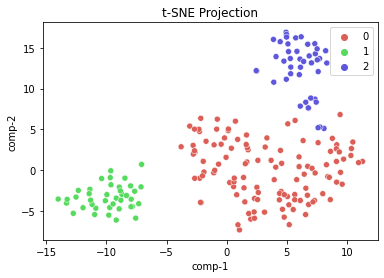

In [ ]:
# Try 2-10 clusters, calculate silhouette score of each
max_sil = -1
best_n = 0
biggest_cluster_labels = []
for n_clusters in range(2, 11):
  cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
  cluster.fit_predict(biggest_clusters)
  sil_score = silhouette_score(biggest_clusters, cluster.labels_)
  if sil_score > max_sil:
    max_sil = sil_score
    best_n = n_clusters
    biggest_cluster_labels = cluster.labels_


# lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
# z = lda.fit_transform(biggest_clusters, labels)

tsne = TSNE(n_components=2, verbose=0)
z = tsne.fit_transform(biggest_clusters)

df = pd.DataFrame()
df["y"] = biggest_cluster_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(biggest_cluster_labels))),
                data=df).set(title="t-SNE Projection")
plt.show()
print("")

Cluster and visualize all cluster centroids for each account

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


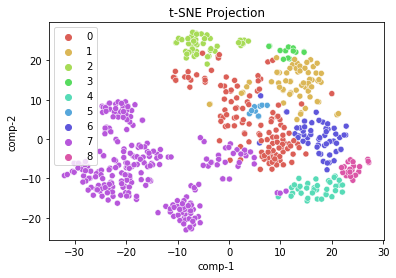

In [ ]:
# Try 2-10 clusters, calculate silhouette score of each
max_sil = -1
best_n = 0
best_labels = []
for n_clusters in range(2, 11):
  cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
  cluster.fit_predict(account_centers)
  sil_score = silhouette_score(account_centers, cluster.labels_)
  if sil_score > max_sil:
    max_sil = sil_score
    best_n = n_clusters
    best_labels = cluster.labels_

# lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
# z = lda.fit_transform(biggest_clusters, labels)

tsne = TSNE(n_components=2, verbose=0)
z = tsne.fit_transform(account_centers)

df = pd.DataFrame() 
df["y"] = best_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", len(set(best_labels))),
                data=df).set(title="t-SNE Projection")
plt.show()
print("")

# Try the same measurements as before on the biggest clusters for each account

In [ ]:
accs, avg_acc = accuracy_by_groups(biggest_clusters, biggest_cluster_labels)
print_accuracy(accs, avg_acc) # Print accuracy by groups for unreduced data

  Accuracy
0 0.9655172413793104
1 1.0
2 0.9545454545454546

Average: 0.9734


In [ ]:
sims, avg = similarity_accross_groups(biggest_clusters, biggest_cluster_labels)
print_similarity_accross_groups(sims, avg) # Print similarity groups for unreduced data

  1     2     3     
1 1.000 0.645 0.692 
2 0.645 1.000 0.482 
3 0.692 0.482 1.000 

Average: 0.606


# Now try the measurements on all the account clusters

In [ ]:
accs, avg_acc = accuracy_by_groups(account_centers, best_labels)
print_accuracy(accs, avg_acc) # Print accuracy by groups for unreduced data

  Accuracy
0 0.2661290322580645
1 0.8548387096774194
2 0.9767441860465116
3 1.0
4 0.9142857142857143
5 1.0
6 0.7735849056603774
7 0.09166666666666666
8 1.0

Average: 0.7641


In [ ]:
sims, avg = similarity_accross_groups(account_centers, best_labels)
print_similarity_accross_groups(sims, avg) # Print similarity groups for unreduced data

  1     2     3     4     5     6     7     8     9     
1 1.000 0.803 0.745 0.625 0.536 0.760 0.913 0.888 0.692 
2 0.803 1.000 0.507 0.806 0.438 0.668 0.773 0.828 0.542 
3 0.745 0.507 1.000 0.571 0.303 0.444 0.583 0.585 0.449 
4 0.625 0.806 0.571 1.000 0.257 0.537 0.487 0.613 0.313 
5 0.536 0.438 0.303 0.257 1.000 0.290 0.650 0.653 0.891 
6 0.760 0.668 0.444 0.537 0.290 1.000 0.583 0.668 0.361 
7 0.913 0.773 0.583 0.487 0.650 0.583 1.000 0.917 0.841 
8 0.888 0.828 0.585 0.613 0.653 0.668 0.917 1.000 0.788 
9 0.692 0.542 0.449 0.313 0.891 0.361 0.841 0.788 1.000 

Average: 0.62


# Calculate the silhouette scores for average embeddings and biggest cluster centers

In [ ]:
# max_sil = -1
# best_n = 0
# best_labels = []
# scores = []
# score_ns = []
# for n_clusters in range(3, 11):
#   cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
#   cluster.fit_predict(embeddings)
#   sil_score = silhouette_score(embeddings, cluster.labels_)
#   scores.append(sil_score)
#   score_ns.append(n_clusters)
#   if sil_score > max_sil:
#     max_sil = sil_score
#     best_n = n_clusters
#     best_labels = cluster.labels_

# plt.plot(score_ns, scores)
# plt.show()

# tsne = TSNE(n_components=2, verbose=0)
# z = tsne.fit_transform(biggest_clusters)

# df = pd.DataFrame()
# df["y"] = best_labels
# df["comp-1"] = z[:,0]
# df["comp-2"] = z[:,1]
# sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
#                 palette=sns.color_palette("hls", len(set(best_labels))),
#                 data=df).set(title="t-SNE Projection")
# plt.show()
# print("")

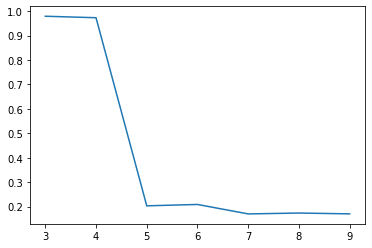

In [ ]:
# Biggest cluster centroids
scores = []
score_ns = []
max_sil = -1
best_n = 0
best_labels = []
for n_clusters in range(3,10):
  cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
  cluster.fit_predict(biggest_clusters)
  sil_score = silhouette_score(biggest_clusters, cluster.labels_)
  scores.append(sil_score)
  score_ns.append(n_clusters)
  if sil_score > max_sil:
    max_sil = sil_score
    best_n = n_clusters
    best_labels = cluster.labels_

plt.plot(score_ns, scores)
plt.show()